Let's do some model development.

We're trying to prod people to spend money. Assuming no long term effects like: retention rates, customer annoyance, long term habit building, customer satisfaction. So we're trying to prod them to spend money over the short term.

Business scenarios:

- Assuming no transaction history built into model.
    - New customer, no demo info, what to offer them.
        - Basically no info at all. Offer aggregate best, or in model solely with customer length.
    - New customer, demo info, what to offer them.
        - Use model based on age, gender, income, possibly in model with customer length.
    - Existing customer, no demo info, what to offer them.
        - Use model based on customer length. Possibly by year as bin.
    - Existing customer, demo info, what to offer them.
        - Use model based on age, gender, income, customer length.
        
So we're looking for a way to pick out which offer to give a customer.

In our data, customers are only exposed to a maximum of 6 offers, with a median of 4 unique offers.


In [71]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Sometimes use display instead of print
from IPython.display import display

# debugging
from IPython.core.debugger import set_trace

In [2]:
# Read the cleaned data
portfolio = pd.read_csv('./data/portfolio_clean.csv')
profile = pd.read_csv('./data/profile_clean.csv')
transcript = pd.read_csv('./data/transcript_clean.csv')

In [3]:
display(portfolio.head())
display(profile.head())
display(transcript.head())

,offer_id,web,email,mobile,social,offer_type,duration,difficulty,reward
0,1,0,1,1,1,bogo,168,10,10
1,2,1,1,1,1,bogo,120,10,10
2,3,1,1,1,0,informational,96,0,0
3,4,1,1,1,0,bogo,168,5,5
4,5,1,1,0,0,discount,240,20,5


,customer_id,gender,age,income,became_member_on
0,1,NaN,NaN,NaN,2017-02-12
1,2,F,55.0,112000.0,2017-07-15
2,3,NaN,NaN,NaN,2018-07-12
3,4,F,75.0,100000.0,2017-05-09
4,5,NaN,NaN,NaN,2017-08-04


,customer_id,time,event,amount,reward,offer_id
0,4,0,offer_received,NaN,NaN,4.0
1,5,0,offer_received,NaN,NaN,5.0
2,6,0,offer_received,NaN,NaN,10.0
3,7,0,offer_received,NaN,NaN,7.0
4,8,0,offer_received,NaN,NaN,2.0


How to define success?

Base line behaviour

Split by customers? yes.

In [4]:
# Merge everything first.
df = transcript.merge(profile, how='left', on='customer_id').merge(portfolio, how='left', on='offer_id')

In [5]:
df = df.rename(columns={'reward_x':'reward_transaction', 'reward_y':'offer_reward'})

In [6]:
df.head()

,customer_id,time,event,amount,reward_transaction,offer_id,gender,age,income,became_member_on,web,email,mobile,social,offer_type,duration,difficulty,offer_reward
0,4,0,offer_received,NaN,NaN,4.0,F,75.0,100000.0,2017-05-09,1.0,1.0,1.0,0.0,bogo,168.0,5.0,5.0
1,5,0,offer_received,NaN,NaN,5.0,NaN,NaN,NaN,2017-08-04,1.0,1.0,0.0,0.0,discount,240.0,20.0,5.0
2,6,0,offer_received,NaN,NaN,10.0,M,68.0,70000.0,2018-04-26,1.0,1.0,1.0,0.0,discount,168.0,10.0,2.0
3,7,0,offer_received,NaN,NaN,7.0,NaN,NaN,NaN,2017-09-25,1.0,1.0,1.0,1.0,discount,240.0,10.0,2.0
4,8,0,offer_received,NaN,NaN,2.0,NaN,NaN,NaN,2017-10-02,1.0,1.0,1.0,1.0,bogo,120.0,10.0,10.0


In [7]:
# A list of individual df's from grouping by customer id.
train_customers, test_customers = train_test_split([e[1] for e in df.groupby('customer_id')], test_size=0.3, random_state=7)

In [8]:
display(len(train_customers))
display(len(test_customers))

11900

5100

In [9]:
def split_transactions_and_offers(customer_list_of_df, transaction_key='transaction'):
    """
    Filters a agglomerated dataframe into transactions and offers.
    
    Input:
    customers_list_of_df - individual customer dfs in a list
    transaction_key      - str for transaction events
    
    Returns:
        List of tuples of transaction and offer event dfs by customer id.
    """
    output = []
    # Iterate through the list and split
    for customer in customer_list_of_df:
        # Mask to get transactions
        select = customer.event == transaction_key
        # Filter for transactions and 
        output.append((customer[select], customer[~select]))
    
    return output
    

In [10]:
train_event_split = split_transactions_and_offers(train_customers)

In [11]:
display(train_event_split[1][0])
print('\n'*4)
display(train_event_split[1][1])

,customer_id,time,event,amount,reward_transaction,offer_id,gender,age,income,became_member_on,web,email,mobile,social,offer_type,duration,difficulty,offer_reward
30713,12595,48,transaction,21.44,NaN,NaN,M,41.0,69000.0,2015-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37876,12595,78,transaction,10.76,NaN,NaN,M,41.0,69000.0,2015-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52027,12595,156,transaction,11.06,NaN,NaN,M,41.0,69000.0,2015-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52927,12595,162,transaction,18.29,NaN,NaN,M,41.0,69000.0,2015-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84814,12595,210,transaction,13.78,NaN,NaN,M,41.0,69000.0,2015-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109659,12595,324,transaction,6.68,NaN,NaN,M,41.0,69000.0,2015-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141015,12595,372,transaction,33.06,NaN,NaN,M,41.0,69000.0,2015-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148467,12595,396,transaction,16.33,NaN,NaN,M,41.0,69000.0,2015-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194570,12595,474,transaction,26.64,NaN,NaN,M,41.0,69000.0,2015-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217389,12595,504,transaction,13.18,NaN,NaN,M,41.0,69000.0,2015-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,customer_id,time,event,amount,reward_transaction,offer_id,gender,age,income,became_member_on,web,email,mobile,social,offer_type,duration,difficulty,offer_reward
9594,12595,0,offer_received,NaN,NaN,10.0,M,41.0,69000.0,2015-11-14,1.0,1.0,1.0,0.0,discount,168.0,10.0,2.0
17451,12595,6,offer_viewed,NaN,NaN,10.0,M,41.0,69000.0,2015-11-14,1.0,1.0,1.0,0.0,discount,168.0,10.0,2.0
30714,12595,48,offer_completed,NaN,2.0,10.0,M,41.0,69000.0,2015-11-14,1.0,1.0,1.0,0.0,discount,168.0,10.0,2.0
62800,12595,168,offer_received,NaN,NaN,6.0,M,41.0,69000.0,2015-11-14,1.0,1.0,1.0,1.0,discount,168.0,7.0,3.0
74126,12595,180,offer_viewed,NaN,NaN,6.0,M,41.0,69000.0,2015-11-14,1.0,1.0,1.0,1.0,discount,168.0,7.0,3.0
84815,12595,210,offer_completed,NaN,3.0,6.0,M,41.0,69000.0,2015-11-14,1.0,1.0,1.0,1.0,discount,168.0,7.0,3.0
116489,12595,336,offer_received,NaN,NaN,8.0,M,41.0,69000.0,2015-11-14,0.0,1.0,1.0,1.0,informational,72.0,0.0,0.0
129356,12595,342,offer_viewed,NaN,NaN,8.0,M,41.0,69000.0,2015-11-14,0.0,1.0,1.0,1.0,informational,72.0,0.0,0.0
160258,12595,408,offer_received,NaN,NaN,5.0,M,41.0,69000.0,2015-11-14,1.0,1.0,0.0,0.0,discount,240.0,20.0,5.0
173541,12595,420,offer_viewed,NaN,NaN,5.0,M,41.0,69000.0,2015-11-14,1.0,1.0,0.0,0.0,discount,240.0,20.0,5.0


# Simple KNN or something for only one type of offer? e.g. offer completion.

If I had to get a very simple classifier working to:
- predict whether off number 1, a bogo offer, was completed or not.
- predict based on demographic data.
    
To do that I would need to classify whether someone:
- got offer 1
- completed offer 1 within the specified duration

I'll split customers into training and validation.

To figure out if customers completed an offer or not, I'll need to:
- filter the transcript for 'offer_received' events for offer 1
- for each 'offer_received' event:
    - filter the transcript for 'offer_completed' events with time >= time of the received event and time <= t + duration

It's like

1) Grab the data by offer
2) Prep the data
3) Do the modelling and report results.
    - KNN pipeline
    - other model pipeline
4) Overall function.

In [12]:
def get_offer_completion_data(transcript_df, profile_df, offer_id, contain_demo=True):
    """
    """
    tr = transcript_df
    pro = profile_df
    
    # Get set of offering completing and non-completing customer ids
    offer_customers = set(tr[(tr.offer_id == offer_id) & (tr.event == 'offer_received')].customer_id)
    offer_completed = set(tr[(tr.offer_id == offer_id) & (tr.event == 'offer_completed')].customer_id)
    offer_incomplete = offer_customers - offer_completed
    
    # Appending 0/1 for incomplete/complete to customer profile data
    profile_complete = pro[pro.customer_id.isin(offer_completed)].assign(offer_complete = 1)
    profile_incomplete = pro[pro.customer_id.isin(offer_incomplete)].assign(offer_complete = 0)
    
    offer_profile = pd.concat([profile_complete, profile_incomplete]).sort_values('customer_id')
    
    # Customers w/ demographic data
    if contain_demo == True:
        offer_profile = offer_profile.dropna()
    # Customers missing demographic data
    else:
        offer_profile = offer_profile[offer_profile.isna().any(axis=1)]
        
    # Clean the data
    ## Get dummies for gender
    offer_profile = pd.concat([offer_profile,
                               pd.get_dummies(offer_profile.gender, prefix="gender")],
                              axis=1)
    # Change membership date to duration in years of how long customer
    # has been a customer.
    customer_duration = pd.to_datetime(offer_profile.became_member_on)
    customer_duration = (customer_duration.max() - customer_duration).dt.days/365
    offer_profile['customer_duration'] = customer_duration
    
    # Drop unnecessary columns
    offer_profile = offer_profile.drop(columns=['gender', 'became_member_on', 'customer_id'])
    
    return offer_profile
    

In [13]:
offer1_profile_demo_info = get_offer_completion_data(transcript, profile, offer_id=1, contain_demo=True)

In [14]:
offer1_profile_demo_info.head()

,age,income,offer_complete,gender_F,gender_M,gender_O,customer_duration
3,75.0,100000.0,1,1,0,0,1.213699
13,61.0,57000.0,1,1,0,0,0.871233
14,26.0,46000.0,0,0,1,0,4.449315
16,49.0,52000.0,1,0,1,0,3.701370
19,61.0,40000.0,0,1,0,0,0.235616


In [15]:
def separate_x_y(df, y_key='offer_complete'):
    """
    """
    # Get X and standardize it.
    # i.e. mean = 0, unit variance
    X = df.drop(columns=y_key)    
    y = df[y_key]
    
    return X, y

In [16]:
X, y = separate_x_y(offer1_profile_demo_info)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=7)

In [114]:
def build_KNN_pipeline_and_fit_CV(X_train, y_train, verbosity=3, n_neighbors_grid=[1,5,10,20,40,80,160,320,640,1000]):
    """
    """
    pipe = Pipeline([('scaler', StandardScaler()),
                         ('knn', KNeighborsClassifier())])
    
    param_grid = [{'knn__n_neighbors': n_neighbors_grid}]
    model = GridSearchCV(pipe, scoring='f1', param_grid=param_grid, cv=5, refit=True, verbose=verbosity, return_train_score=True)
    
    model.fit(X_train, y_train)
    
    print(f"Best params: {model.best_params_}.")
    print(f"Best score: {round(model.best_score_, 5)}.")
    
    return model

In [115]:
knn_model = build_KNN_pipeline_and_fit_CV(X_train, y_train, verbosity=1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 160}.
Best score: 0.75268.


In [94]:
train_score, validation_score = model.cv_results_['mean_train_score'], model.cv_results_['mean_test_score']

In [95]:
n_neighbors = [e['knn__n_neighbors'] for e in model.cv_results_['params']]

Text(0, 0.5, 'f1 score')

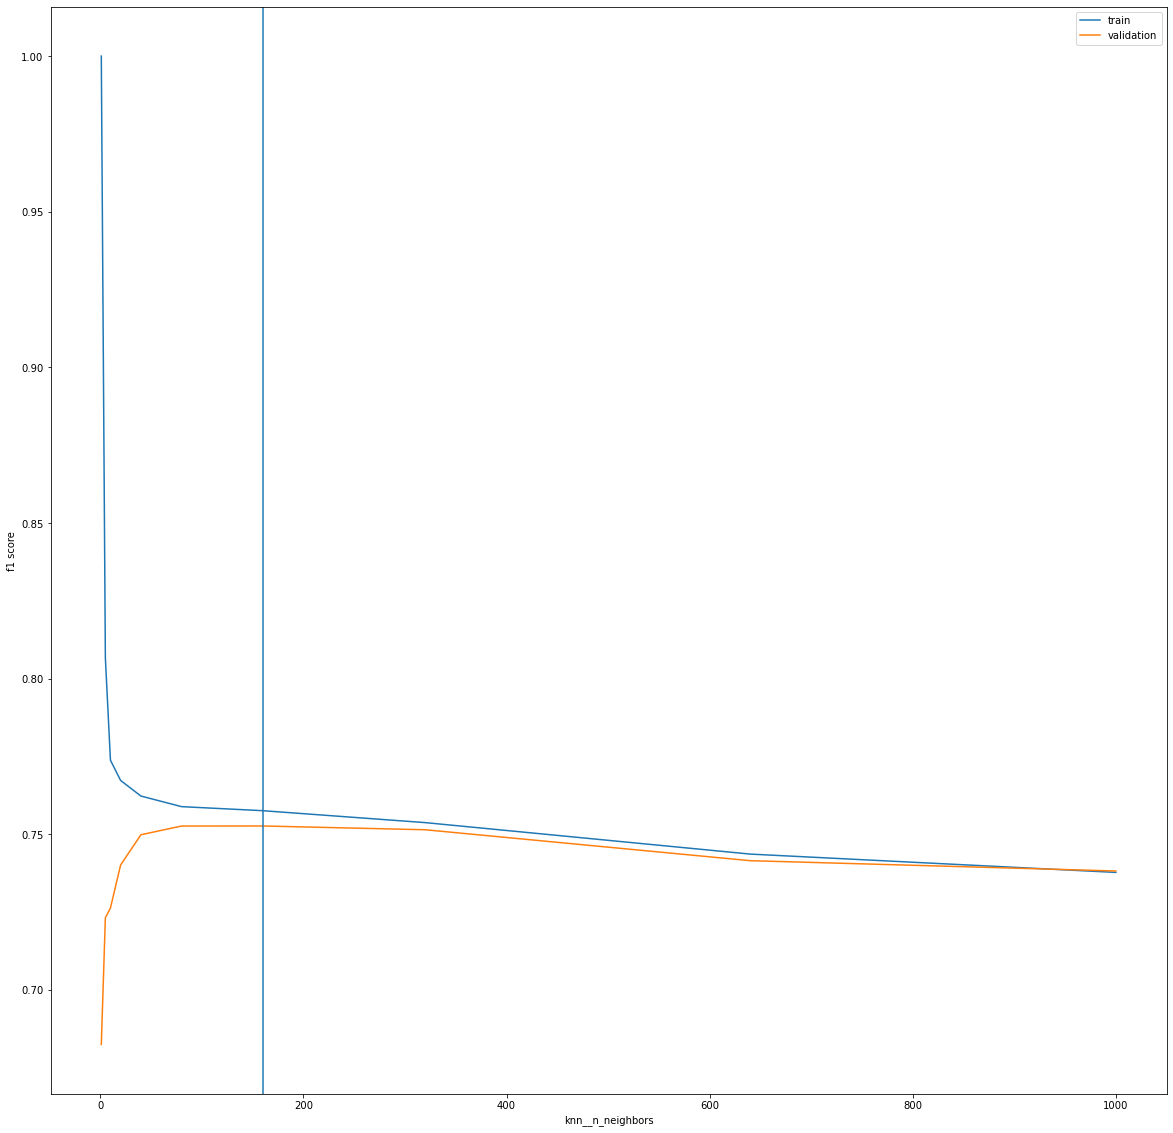

In [96]:
fig, ax = plt.subplots(figsize=(20,20))
param = 'knn__n_neighbors'
sns.lineplot(ax=ax, x=n_neighbors, y=train_score, label='train')
sns.lineplot(ax=ax, x=n_neighbors, y=validation_score, label='validation')
ax.axvline(model.best_params_[param])
ax.set_xlabel(param)
ax.set_ylabel('f1 score')

In [120]:
def build_RFC_pipeline_and_fit_CV(X_train,
                                  y_train,
                                  verbosity=3,
                                  param_grid=[{'rfc__n_estimators': [10, 100],
                                               'rfc__max_depth': [100, None],
                                               'rfc__min_samples_split': [2, 5, 10, 20],
                                               'rfc__min_samples_leaf': [1, 2, 4, 8]
                                             }],
                                  random_state=7):
    """
    
    See https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    for hyperparameter tuning example.
    """
    pipe = Pipeline([('scaler', StandardScaler()),
                         ('rfc', RandomForestClassifier())])
    
 
    
    model = GridSearchCV(pipe, scoring='f1', param_grid=param_grid, cv=5, refit=True, verbose=verbosity, return_train_score=True)
    
    model.fit(X_train, y_train)
    
    print(f"Best params: {model.best_params_}.")
    print(f"Best score: {round(model.best_score_, 5)}.")
    
    return model

In [121]:
rfc_model = build_RFC_pipeline_and_fit_CV(X_train, y_train, verbosity=1)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'rfc__max_depth': 100, 'rfc__min_samples_leaf': 4, 'rfc__min_samples_split': 20, 'rfc__n_estimators': 100}.
Best score: 0.757.


In [86]:
train_score, validation_score = model.cv_results_['mean_train_score'], model.cv_results_['mean_test_score']

In [87]:
train_score

array([0.98254339, 1.        , 0.93991335, 0.96464543, 0.88691005,
       0.90507795, 0.84463799, 0.85330788, 0.92081397, 0.93995263,
       0.91094013, 0.93107407, 0.87255846, 0.89022456, 0.83483151,
       0.84708842, 0.85445124, 0.87065653, 0.85624749, 0.86876633,
       0.85431851, 0.86562185, 0.82569737, 0.83304028, 0.81352775,
       0.81935636, 0.81342766, 0.81875147, 0.8087439 , 0.81899697,
       0.80930552, 0.81532946, 0.98188785, 1.        , 0.93847449,
       0.96468925, 0.88637947, 0.9058702 , 0.84262568, 0.85395087,
       0.91918705, 0.94090998, 0.91235062, 0.933516  , 0.87315428,
       0.88898873, 0.83544978, 0.84690839, 0.85610549, 0.86943923,
       0.85510693, 0.86912518, 0.85116979, 0.86248616, 0.82597136,
       0.83361615, 0.81351975, 0.81986142, 0.81107889, 0.81872757,
       0.81529678, 0.81989344, 0.80872209, 0.81436226])

In [89]:
validation_score

array([0.7088786 , 0.73813028, 0.72127298, 0.73738992, 0.73583506,
       0.74611908, 0.74230277, 0.74709812, 0.73801003, 0.7456602 ,
       0.73986275, 0.74289144, 0.74039901, 0.74668956, 0.74031026,
       0.74963754, 0.7465066 , 0.75203055, 0.75227743, 0.74795732,
       0.74034603, 0.75201544, 0.74832455, 0.75326645, 0.74769069,
       0.75614898, 0.74799621, 0.75447042, 0.7506032 , 0.75562348,
       0.75125941, 0.7572464 , 0.71109864, 0.73015445, 0.73355162,
       0.73908959, 0.73087501, 0.74414265, 0.74139442, 0.74741287,
       0.72836415, 0.74411061, 0.73798208, 0.74155016, 0.73545232,
       0.74477529, 0.74372563, 0.75341379, 0.74017706, 0.75087385,
       0.74641565, 0.75004382, 0.75195808, 0.75055949, 0.7548109 ,
       0.75330201, 0.75387808, 0.75659579, 0.75081646, 0.75700085,
       0.75347559, 0.75519809, 0.74637297, 0.75537234])

In [88]:
model.best_score_

0.757246402502699

In [69]:
n_neighbors = [e['knn__n_neighbors'] for e in model.cv_results_['params']]

Text(0, 0.5, 'f1 score')

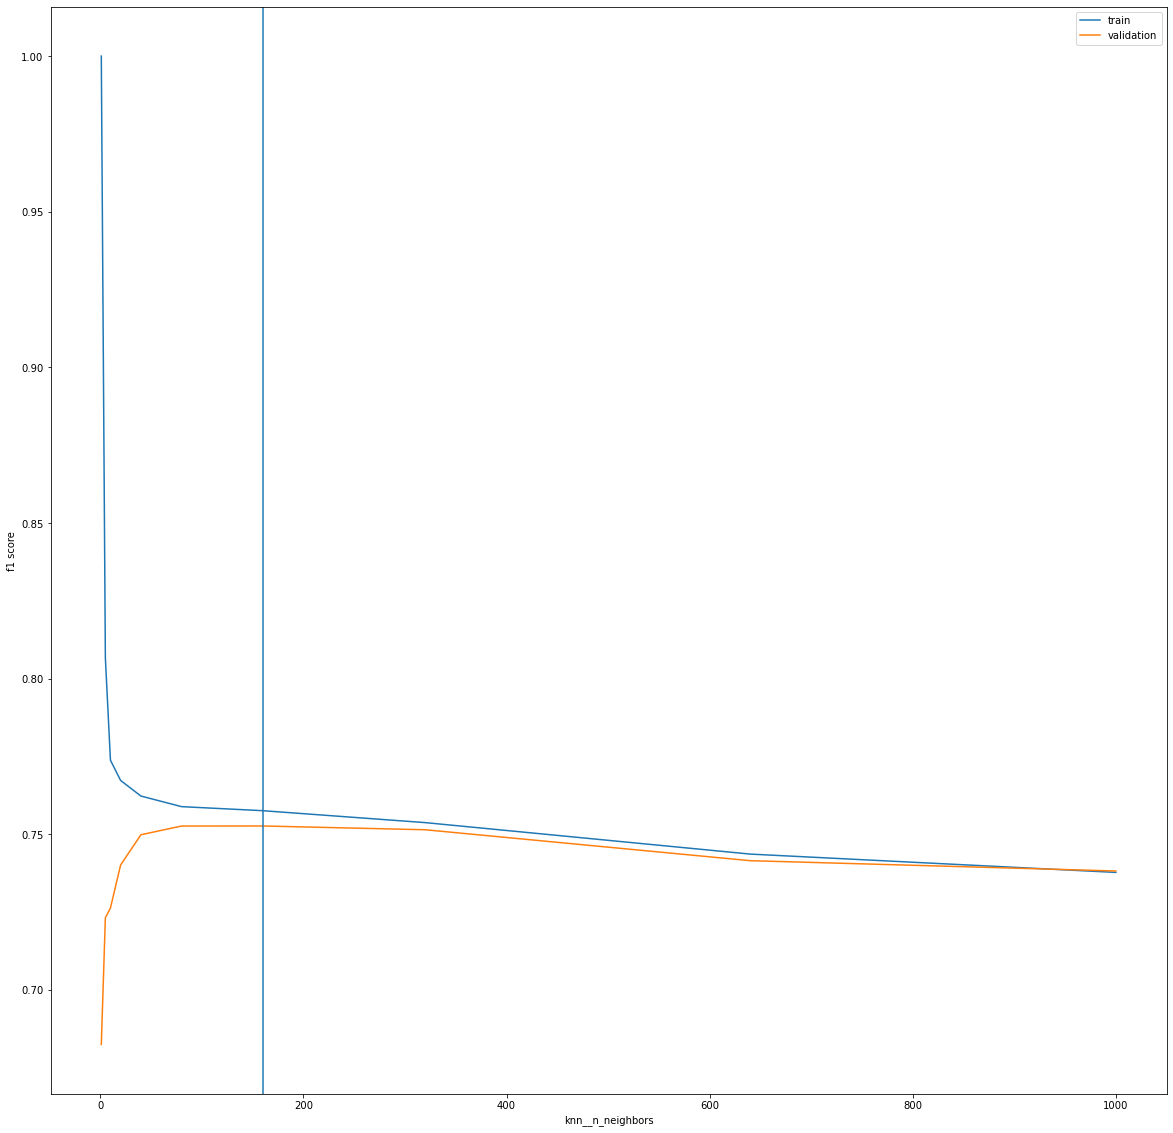

In [70]:
fig, ax = plt.subplots(figsize=(20,20))
param = 'knn__n_neighbors'
sns.lineplot(ax=ax, x=n_neighbors, y=train_score, label='train')
sns.lineplot(ax=ax, x=n_neighbors, y=validation_score, label='validation')
ax.axvline(model.best_params_[param])
ax.set_xlabel(param)
ax.set_ylabel('f1 score')

In [20]:
def build_KNN_and_predict(X_train, X_test, y_train, y_test, n_neighbors=5):
    """
    """
    # Scale on training data
    scaler = StandardScaler()
      
    X_train = scaler.fit(X_train).transform(X_train)
    X_test = scaler.transform(X_test)
    # Fit and predict
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    y_train_preds = knn.predict(X_train)
    y_preds = knn.predict(X_test)
    
    train_f1_score = f1_score(y_train, y_train_preds)
    test_f1_score = f1_score(y_test, y_preds)
    
    return knn, train_f1_score, test_f1_score

In [21]:
model, train_score, test_score = build_KNN_and_predict(X_train, X_test, y_train, y_test, n_neighbors=20)
print(f"Train score: {round(train_score, 4)}. Test score: {round(test_score, 4)}.")

Train score: 0.7662. Test score: 0.7477.


## References

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74